<a href="https://colab.research.google.com/github/thisisutkarsh/Landmark-classification-using-deep-learning/blob/master/landmark_final_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project: Landmark Classification Using Deep Learning

---
### Why Landmark Classification

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernable landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.


### The Road Ahead

The major steps of our project - 

* [Step 0](#step0): Download Datasets and Install Python Modules.
* [Step 1](#'step1'): Create a CNN to Classify Landmarks (from Scratch).
* [Step 2](#step2): Create a CNN to Classify Landmarks (using Transfer Learning).
* [Step 3](#step3): Write Your Landmark Prediction Algorithm

---
<a id='step0'></a>

## Step 0: Download Datasets and Install Python Modules

Dataset Used- [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip)

Python modules needed-
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, we will create a CNN that classifies landmarks from scratch.

**Target accuracy -  20 % **.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%.

### Specify Data Loaders for the Landmark Dataset

Create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): 
one for training data, one for validation data, and one for test data. 
Randomly splitted the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!unzip /content/drive/MyDrive/Landmark-classification/landmark_images_2.zip >/dev/null

replace landmark_images/README.md? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [6]:
! pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import torch
from torchvision import datasets, transforms
import numpy as np
import splitfolders

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
# Create Transforms
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    # Augmentation
    transforms.RandomHorizontalFlip(p=0.3), 
    transforms.RandomRotation(10),
    transforms.RandomChoice([
            transforms.ColorJitter(hue=0.1),
            transforms.ColorJitter(brightness=0.2),
            transforms.ColorJitter(saturation=0.2),
            transforms.ColorJitter(contrast=0.2),
        ]),
    # -------------
    transforms.ToTensor(),
    transforms.Normalize(mean, std) # Imagenet standards
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std) # Imagenet standards
])

# Split the training folder to new training and validation folders
splitfolders.ratio("landmark_images/train", output="train_valid", seed=1337, ratio=(.8, .2), group_prefix=None)

# Load the image data
train_data = datasets.ImageFolder('./train_valid/train', transform=train_transform)
valid_data = datasets.ImageFolder('./train_valid/val', transform=test_transform)
test_data = datasets.ImageFolder('landmark_images/test', transform=test_transform)

# Save classes names 
n_classes = len(train_data.classes)
classes = [class_.split(".")[1].replace("_", " ") for class_ in train_data.classes]

print('\n Num training images: ',   len(train_data))
print('Num validation images: ', len(valid_data))
print('Num test images: ',       len(test_data))

batch_size = 20
# Create data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size, shuffle=True)


loaders_scratch = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}


Copying files: 4996 files [00:01, 2611.55 files/s]



 Num training images:  3996
Num validation images:  1000
Num test images:  1250


## Data Augmentation
- firstly, I randomly resized crop the images to 224x224 pixels for training. But for testing, I did normal resized to 256, then center crop to 224x224 pixels size. After conducting some research, I have picked 224x224 pixels as the size of the input tensor since it appears a pretty typical and suitable size for an image, and it is inspired by the input image size of vgg-16 that has been trained on the imagenet data. Then, the image is transformed to a tensor and normalized to the imagenet normalization values; these values are calculated based on millions of images, so it is recommended to use.

- Data augmentation has been applied on just the training subset of the dataset through random rotations of 10 degrees and random horizontal flips to the images, also with random and different color jitters.

###   Visualize a Batch of Training Data

Rretrieve a batch of images from the train data loader, display at least 5 images simultaneously, and labeled each displayed image with its class name (e.g., "Golden Gate Bridge").

In [8]:
def unnormlize(img, s, m):
    return img * s[:, None, None] + m[:, None, None]

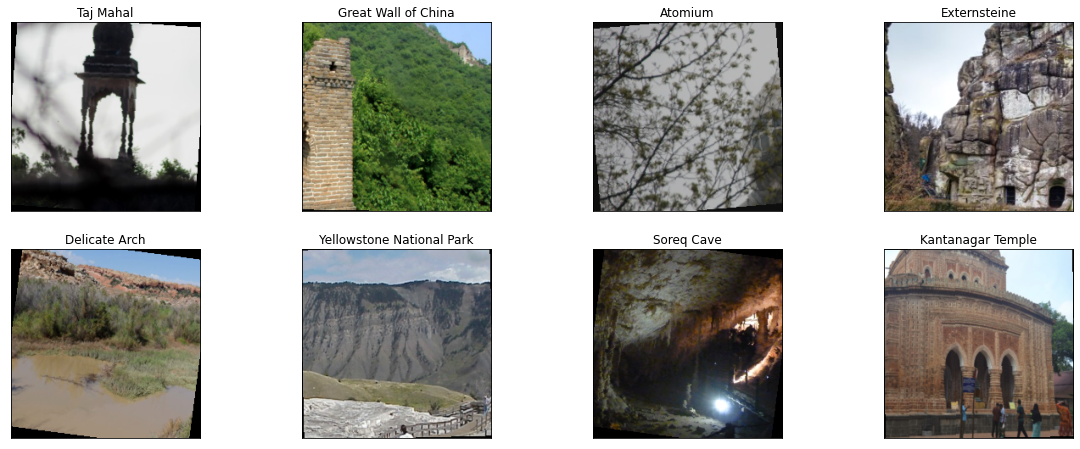

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

# visualize a batch of the train data loader
import random

fig = plt.figure(figsize=(20,2*8))
for idx in range(8):
    ax = fig.add_subplot(4, 4, idx+1, xticks=[], yticks=[], )
    rand_img = random.randint(0, len(train_data))

    img = unnormlize(train_data[rand_img][0], torch.Tensor(std), torch.Tensor(mean)) # unnormalize
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0))) # convert from Tensor image
    class_name = classes[train_data[rand_img][1]]
    ax.set_title(class_name)

### Initialize use_cuda variable

In [10]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()

### Specify Loss Function and Optimizer

In [11]:
## select loss function
import torch.nn as nn
import torch.optim as optim

criterion_scratch = nn.CrossEntropyLoss() 

def get_optimizer_scratch(model):
    ## select and return an optimizer
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    return optimizer

### Model Architecture

Create a CNN

In [12]:
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    # choose an architecture
    def __init__(self):
        super(Net, self).__init__()

        ## Define layers of a CNN
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        
        
        # Max pooling layer (divides the image by a factor of 2)
        self.pool = nn.MaxPool2d(2, 2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(28 * 28 * 64, 256)
        self.fc2 = nn.Linear(256, n_classes) # n_classes = 50
        
        # Dropout
        self.dropout = nn.Dropout(0.3)
        
        # Activation function
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.2)
        
        # Batch norm
        self.batch_norm2d = nn.BatchNorm2d(32)
        self.batch_norm1d = nn.BatchNorm1d(256)
        
    
    def forward(self, x):
        # Define forward behavior
        # sequence of convolutional and max pooling layers
        x = self.pool(self.leaky_relu(self.conv1(x)))
        x = self.pool(self.leaky_relu(self.conv2(x)))
        x = self.batch_norm2d(x)
        x = self.pool(self.leaky_relu(self.conv3(x)))
        
        # flatten the image
        x = x.view(-1, 28 * 28 * 64)
        
        # dropout layer
        x = self.dropout(x)
        
        # 1st hidden layer
        x = self.leaky_relu(self.fc1(x))
        
        x = self.batch_norm1d(x)
        
        # dropout layer
        x = self.dropout(x)
        
        # final layer
        x = self.fc2(x)
        
        return x

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

In [14]:
model_scratch

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=50, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (leaky_relu): LeakyReLU(negative_slope=0.2)
  (batch_norm2d): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm1d): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [13]:
!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
from torchsummary import summary 

summary(model_scratch, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
         LeakyReLU-2         [-1, 16, 224, 224]               0
         MaxPool2d-3         [-1, 16, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]           4,640
         LeakyReLU-5         [-1, 32, 112, 112]               0
         MaxPool2d-6           [-1, 32, 56, 56]               0
       BatchNorm2d-7           [-1, 32, 56, 56]              64
            Conv2d-8           [-1, 64, 56, 56]          18,496
         LeakyReLU-9           [-1, 64, 56, 56]               0
        MaxPool2d-10           [-1, 64, 28, 28]               0
          Dropout-11                [-1, 50176]               0
           Linear-12                  [-1, 256]      12,845,312
        LeakyReLU-13                  [-1, 256]               0
      BatchNorm1d-14                  [

 
For choosing the model architecture, I make use of this [article](https://towardsdatascience.com/a-guide-to-an-efficient-way-to-build-neural-network-architectures-part-ii-hyper-parameter-42efca01e5d7) for general tips. Here, I was focused on building a simple architecture as much as possible that satisfy the task pretty well. So, the model is defined by the following steps:

**Convolutional and Max pooling layers:**
- Conv1 - 224x224 16 | Leaky relu activation function
- Max pooling using a 2x2 kernel and a stride of 2

- Conv2 - 112x112 32 | Leaky relu activation function
- Max pooling using a 2x2 kernel and a stride of 2
- Batch Normalization

- Conv3 - 56x56 64 | Leaky relu activation function
- Max pooling using a 2x2 kernel and a stride of 2


**Fully connected layers and dropout:**
- Dropout of 30% probability
- Fully connected layer (28x28 64, 256) | Leaky relu activation function
- Batch Normalization

- Dropout of 30% probability 
- Fully connected layer (256, n_classes=50)


Dropout has been used to avoid overfitting and Max-pooling layers to focus on the main target features via dividing the image by a factor of 2. I attempted to speed up the training process and to perform some regularization to the model via Batch Normalization.

### Implement the Training Algorithm

In [16]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
       
        # train the model #
      
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            # find the loss and update the model parameters accordingly
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            ## record the average training loss, using something like
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))

                
        # validate the model #
        
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## update average validation loss 
            output = model(data)
            loss = criterion(output, target)
            valid_loss += ((1 / (batch_idx + 1)) * (loss.data.item() - valid_loss))
            
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, 
                                                                                   train_loss,
                                                                                   valid_loss))

        # if the validation loss has decreased, save the model at the filepath stored in save_path
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,
                                                                                            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
        
        
    return model

###   Experiment with the Weight Initialization

define a custom weight initialization, and then train with weight initialization for a few epochs.
Used https://gist.github.com/jojonki/be1e8af97dfa12c983446391c3640b68

In [17]:
def custom_weight_init(m):
    if isinstance(m, nn.Conv2d):
        n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
        m.weight.data.normal_(0, np.sqrt(2. / n))
        if m.bias is not None:
            m.bias.data.zero_()
    elif isinstance(m, nn.BatchNorm2d):
        m.weight.data.fill_(1)
        m.bias.data.zero_()
    elif isinstance(m, nn.Linear):
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.normal_(0, y)
        m.bias.data.zero_()

    
model_scratch.apply(custom_weight_init)
model_scratch = train(20, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),
                      criterion_scratch, use_cuda, 'ignore.pt')

Epoch: 1 	Training Loss: 3.950300 	Validation Loss: 3.465441
Validation loss decreased (inf --> 3.465441).  Saving model ...
Epoch: 2 	Training Loss: 3.656349 	Validation Loss: 3.291432
Validation loss decreased (3.465441 --> 3.291432).  Saving model ...
Epoch: 3 	Training Loss: 3.538133 	Validation Loss: 3.203116
Validation loss decreased (3.291432 --> 3.203116).  Saving model ...
Epoch: 4 	Training Loss: 3.422565 	Validation Loss: 3.147484
Validation loss decreased (3.203116 --> 3.147484).  Saving model ...
Epoch: 5 	Training Loss: 3.376906 	Validation Loss: 3.103329
Validation loss decreased (3.147484 --> 3.103329).  Saving model ...
Epoch: 6 	Training Loss: 3.311867 	Validation Loss: 3.020819
Validation loss decreased (3.103329 --> 3.020819).  Saving model ...
Epoch: 7 	Training Loss: 3.261579 	Validation Loss: 2.965852
Validation loss decreased (3.020819 --> 2.965852).  Saving model ...
Epoch: 8 	Training Loss: 3.211609 	Validation Loss: 2.929881
Validation loss decreased (2.96585

Train and validate the model

In [18]:

num_epochs = 20 

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)

# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch), 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 3.738585 	Validation Loss: 3.411027
Validation loss decreased (inf --> 3.411027).  Saving model ...
Epoch: 2 	Training Loss: 3.495521 	Validation Loss: 3.253103
Validation loss decreased (3.411027 --> 3.253103).  Saving model ...
Epoch: 3 	Training Loss: 3.386643 	Validation Loss: 3.160344
Validation loss decreased (3.253103 --> 3.160344).  Saving model ...
Epoch: 4 	Training Loss: 3.268030 	Validation Loss: 3.065379
Validation loss decreased (3.160344 --> 3.065379).  Saving model ...
Epoch: 5 	Training Loss: 3.239637 	Validation Loss: 3.022253
Validation loss decreased (3.065379 --> 3.022253).  Saving model ...
Epoch: 6 	Training Loss: 3.164316 	Validation Loss: 2.934831
Validation loss decreased (3.022253 --> 2.934831).  Saving model ...
Epoch: 7 	Training Loss: 3.106808 	Validation Loss: 2.908651
Validation loss decreased (2.934831 --> 2.908651).  Saving model ...
Epoch: 8 	Training Loss: 3.056570 	Validation Loss: 2.864385
Validation loss decreased (2.90865

### Test the Model

In [19]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()

        # forward pass: compute predicted outputs by passing inputs to the model

        output = model(data)

        # calculate the loss

        loss = criterion(output, target)

        # update average test loss 

        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))

        # convert output probabilities to predicted class

        pred = output.data.max(1, keepdim=True)[1]

        # compare predictions to true label

        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# load the model that got the best validation accuracy

model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 2.422639


Test Accuracy: 41% (513/1250)


---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)


### Specify Data Loaders for the Landmark Dataset

Used following code for [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

In [20]:


loaders_transfer = loaders_scratch.copy()


### Specify Loss Function and Optimizer

In [21]:
# loss function
criterion_transfer = nn.CrossEntropyLoss() 


def get_optimizer_transfer(model):
  #Optimizer

    optimizer = optim.SGD(model.classifier.parameters(), lr=0.01)
    return optimizer
    

### Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.

In [22]:
from torchvision import models

model_transfer = models.vgg16(pretrained=True)

# Freeze training for all "features" layers
for parameter in model_transfer.features.parameters():
    parameter.requires_grad = False
    

n_input = model_transfer.classifier[6].in_features
model_transfer.classifier[6] = nn.Linear(n_input, n_classes) # n_classes = 50


if use_cuda:
    model_transfer = model_transfer.cuda()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

__Answer:__  
We used the VGG-16 model as a pretrained model because it has been trained on millions of images. Since we have a small dataset and quite similar data, we only replaced the last fully connected layer of the model with one of our own problem to output 50 classes. Additionally, we froze the parameters of all the features layers of the model and left the parameters of the classifier part for training.

### Train and Validate the Model


In [23]:
# train the model and save the best model parameters at filepath 'model_transfer.pt'
train(15, loaders_transfer, model_transfer, get_optimizer_transfer(model_transfer), criterion_transfer,
      use_cuda, 'model_transfer.pt')

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 2.575790 	Validation Loss: 1.518722
Validation loss decreased (inf --> 1.518722).  Saving model ...
Epoch: 2 	Training Loss: 1.701552 	Validation Loss: 1.264939
Validation loss decreased (1.518722 --> 1.264939).  Saving model ...
Epoch: 3 	Training Loss: 1.511878 	Validation Loss: 1.175913
Validation loss decreased (1.264939 --> 1.175913).  Saving model ...
Epoch: 4 	Training Loss: 1.386186 	Validation Loss: 1.122759
Validation loss decreased (1.175913 --> 1.122759).  Saving model ...
Epoch: 5 	Training Loss: 1.317066 	Validation Loss: 1.104625
Validation loss decreased (1.122759 --> 1.104625).  Saving model ...
Epoch: 6 	Training Loss: 1.236747 	Validation Loss: 1.099185
Validation loss decreased (1.104625 --> 1.099185).  Saving model ...
Epoch: 7 	Training Loss: 1.204895 	Validation Loss: 1.038353
Validation loss decreased (1.099185 --> 1.038353).  Saving model ...
Epoch: 8 	Training Loss: 1.140633 	Validation Loss: 1.017422
Validation loss decreased (1.03835

<All keys matched successfully>

### Test the Model

In [25]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.800536


Test Accuracy: 78% (979/1250)


Testing with input

In [24]:
!unzip /content/drive/MyDrive/Landmark-classification/test_images.zip >/dev/null

In [27]:
import cv2
from PIL import Image


def predict_landmarks(img_path, k):
    ## return the names of the top k landmarks predicted by the transfer learned CNN
    img = Image.open(img_path).convert('RGB')
    
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    
    img = transform(img)
    img.unsqueeze_(0)
    
    if use_cuda:
        img = img.cuda()
        
    model_transfer.eval()
    output = model_transfer(img)
    top_values, top_idx = output.topk(k)

    top_classes = [classes[class_id] for class_id in top_idx[0].tolist()]
    return top_classes

# test on a sample image
predict_landmarks('test_images/10.Edinburgh_Castle.jpeg', 5)

['Edinburgh Castle',
 'Whitby Abbey',
 'Machu Picchu',
 'Great Wall of China',
 'Ljubljana Castle']

In [38]:
def suggest_locations(img_path):
    # get landmark predictions
    predicted_landmarks = predict_landmarks(img_path, 3)
    
    ##display image and display landmark predictions
    img = Image.open(img_path).convert('RGB')
    plt.imshow(img)
    plt.show()

    print(f"Actual Label: {img_path.split('/')[2][3:].replace('_',' ').split('.')[0]}")
    print(f"Predicted Label in order: Is this picture of the\n {predicted_landmarks[0]}, {predicted_landmarks[1]}, or {predicted_landmarks[2]}?")
    

# test on a sample image
# suggest_locations('test_images/10.Edinburgh_Castle.jpeg')

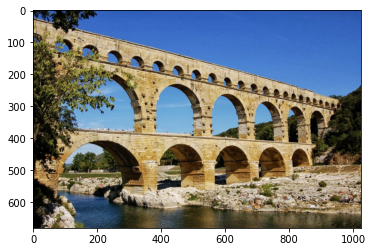

Actual Label: Pont du Gard
Predicted Label in order: Is this picture of the
 Pont du Gard, Taj Mahal, or Ljubljana Castle?


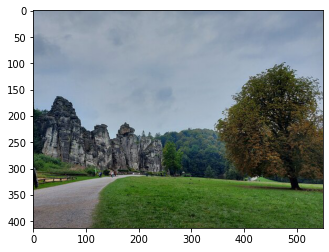

Actual Label: Externsteine
Predicted Label in order: Is this picture of the
 Temple of Olympian Zeus, Stonehenge, or Externsteine?


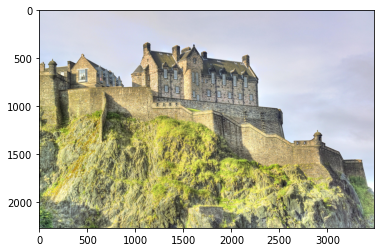

Actual Label: Edinburgh Castle
Predicted Label in order: Is this picture of the
 Edinburgh Castle, Whitby Abbey, or Machu Picchu?


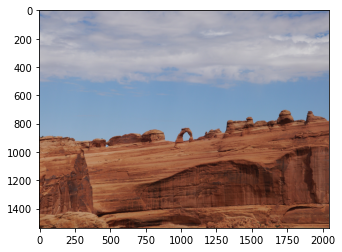

Actual Label: Delicate Arch
Predicted Label in order: Is this picture of the
 Delicate Arch, Badlands National Park, or Dead Sea?


In [37]:
import os

for img_path in os.listdir('./test_images'):
    img_path = os.path.join('./test_images', img_path)
    if img_path.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')):
        suggest_locations(img_path)